## Habitat Suitability 

##### Data wrangling

Import Libraries

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pathlib
import zipfile
from glob import glob
from math import floor, ceil

import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray as rxr
# Merge rasters
from rioxarray.merge import merge_arrays
import xarray as xr
import xrspatial

import matplotlib.pyplot as plt
# interactive plots of vector data
import hvplot.pandas

import earthaccess

Set Paths

In [3]:
# Images
images_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Projects',
    # Project directory
    'habitat-suitability',
    'images'
)

# Datasets
datasets_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Projects',
    # Project directory
    'habitat-suitability',
    'datasets'
)

# Project data directory 
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Projects',
    # Project directory
    'habitat-suitability',
    'data'
)

# Define directories for data
land_units_dir = os.path.join(data_dir, 'usfs-national-lands')
eldorado_elevation_dir = os.path.join(data_dir, 'srtm', 'eldorado')
los_padres_elevation_dir = os.path.join(data_dir, 'srtm', 'los_padres')

os.makedirs(images_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(eldorado_elevation_dir, exist_ok=True)
os.makedirs(los_padres_elevation_dir, exist_ok=True)

Load Utility Functions

In [4]:
def build_da(urls, bounds):
    """Build a DataArray from a list of urls"""
    all_das = []

    # Add buffer to bounds for plotting
    buffer = .025
    xmin, ymin, xmax, ymax = bounds
    bounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)

    for url in urls:
        # Open data granule, mask missing data, scale data, and remove dimensions of length 1
        tile_da = rxr.open_rasterio(
                url,
                # For the fill/missing value
                mask_and_scale=True
            ).squeeze()
        # Unpack the bounds and crop tile
        cropped_da = tile_da.rio.clip_box(*bounds_buffer)
        all_das.append(cropped_da)

    merged = merge_arrays(all_das)
    return merged

In [6]:
def convert_longitude(longitude):
    """Convert longitude values from a range of 0 to 360 to -180 to 180"""
    return (longitude - 360) if longitude > 180 else longitude

In [46]:
def reproject_das(das, target_da):
    """Reproject DataArrays to a target DataArray and combine into a raster"""

    total_das = []

    for da in das:
        # Reproject the DataArray to match the resolution, projection, and region of a target DataArray 
        reprojected_da = da.rio.reproject_match(target_da)
        
        # Append the reprojected DataArray to the total_das list 
        total_das.append(reprojected_da)
    
    # Merge total_das into a single DataArray 
    merged = merge_arrays(total_das)

    # Convert DataArray to raster 
    merged.rio.to_raster("final_site.tif")

    return merged

In [7]:
def plot_site(site_da, site_gdf, site_fig_name, plot_title, bar_label, plot_cmap, boundary_clr):
    """Create custom site plot"""
    fig = plt.figure(figsize=(8, 6)) 
    ax = plt.axes()

    # Plot DataArray values
    site_plot = site_da.plot(cmap=plot_cmap, cbar_kwargs={'label': bar_label})

    # Plot site boundary
    site_gdf.boundary.plot(ax=plt.gca(), color=boundary_clr)

    plt.title(f'{plot_title}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    fig.savefig(f"{images_dir}/{site_fig_name}.png") 

    return site_plot

Load Data

In [10]:
# Only extract once
usfs_pattern = os.path.join(land_units_dir, '*.shp')

if not glob(usfs_pattern):
    usfs_zip = f'{datasets_dir}/S_USA.NFSLandUnit.zip'

    # Unzip data
    with zipfile.ZipFile(usfs_zip, 'r') as zip:
        zip.extractall(path=land_units_dir)

# Find the extracted .shp file path
usfs_land_path = glob(usfs_pattern)[0]

# Load USFS land units from shapefile
usfs_land_units_gdf = (
    gpd.read_file(usfs_land_path)
)

# Obtain units with location name
valid_units = usfs_land_units_gdf.dropna(subset=['HQ_LOCATIO'])

# Select only CA units
all_ca_units = valid_units[valid_units['HQ_LOCATIO'].str.contains('CA')]

In [11]:
earthaccess.login(strategy="interactive", persist=True)

In [12]:
# Search for Digital Elevation Models

ea_dem = earthaccess.search_datasets(keyword='SRTM DEM', count=15)
for dataset in ea_dem:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002
GFSAD30EUCEARUMECE Global Food Security-support Analysis Data (GFSAD) Cropland Extent 2015 Europe, Central Asia, Russia, Middle East product 30 m V001
GFSAD30SA

Explore Sites

In [13]:
# Los Padres National Forest
los_padres_gdf = all_ca_units.loc[all_ca_units['NFSLANDU_2'] == 'Los Padres National Forest']

# plot with EsriImagery basemap  
los_padres_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title='Los Padres National Forest',
    fill_color=None, line_color='lightblue', line_width=3,
    frame_width=600, frame_height=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [14]:
# Eldorado National Forest
eldorado_gdf = all_ca_units.loc[all_ca_units['NFSLANDU_2'] == 'Eldorado National Forest']

# plot with EsriImagery basemap  
eldorado_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title='Eldorado National Forest',
    fill_color=None, line_color='lightblue', line_width=3,
    frame_width=600, frame_height=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

Identify Soil Metric

In [15]:
def create_polaris_urls(soil_prop, stat, soil_depth, gdf_bounds):
    """Create POLARIS dataset urls using site bounds"""

    # Get latitude and longitude bounds from site
    min_lon, min_lat, max_lon, max_lat = gdf_bounds

    site_min_lon = floor(min_lon) 
    site_min_lat = floor(min_lat)  
    site_max_lon = ceil(max_lon)  
    site_max_lat = ceil(max_lat)

    all_soil_urls = []

    for lon in range(site_min_lon, site_max_lon): 
        for lat in range(site_min_lat, site_max_lat):
            current_max_lon = lon + 1
            current_max_lat = lat + 1

            soil_template = (
                "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
                "{soil_prop}/"
                "{stat}/"
                "{soil_depth}/"
                "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
            )

            soil_url = soil_template.format(
                soil_prop=soil_prop, stat=stat, soil_depth=soil_depth,
                min_lat=lat, max_lat=current_max_lat, 
                min_lon=lon, max_lon=current_max_lon
            )

            all_soil_urls.append(soil_url)

    return all_soil_urls

In [16]:
# Set site parameters
soil_prop = 'ph'
soil_prop_stat = 'mean'
# cm (the minimum depth for blue oaks is 1-2 ft)
soil_depth = '30_60'

# Build soil DataArrays 

# Eldorado site
ed_polaris_urls = create_polaris_urls(soil_prop, soil_prop_stat, soil_depth, eldorado_gdf.total_bounds)
eldorado_da = build_da(ed_polaris_urls, tuple(eldorado_gdf.total_bounds))

# Los Padres site
lp_polaris_urls = create_polaris_urls(soil_prop, soil_prop_stat, soil_depth, los_padres_gdf.total_bounds)
los_padres_da = build_da(lp_polaris_urls, tuple(los_padres_gdf.total_bounds))

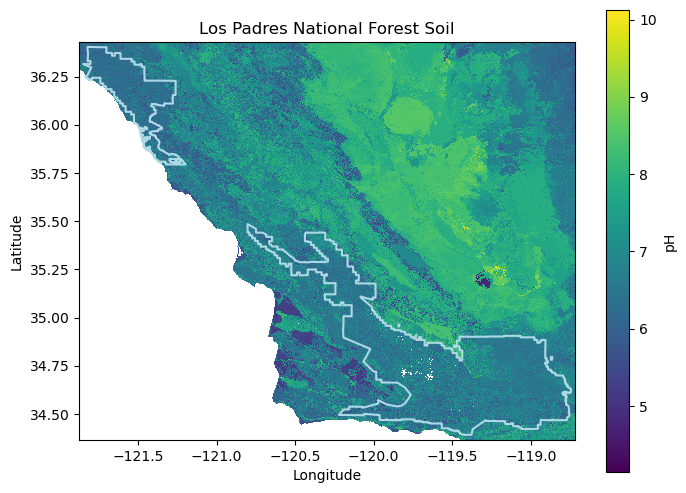

In [17]:
# Plot Los Padres soils

los_padres_soil_plt = plot_site(
    los_padres_da, los_padres_gdf, 
    'Los-Padres-National-Forest-Soil', 
    'Los Padres National Forest Soil', 
    'pH', 'viridis', 'lightblue'
)

los_padres_soil_plt

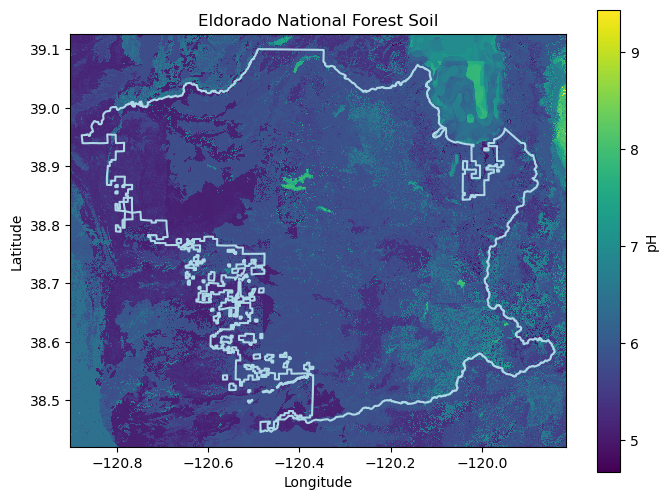

In [18]:
# Plot Eldorado soils

eldorado_soil_plt = plot_site(
    eldorado_da, eldorado_gdf, 
    'Eldorado-National-Forest-Soil', 
    'Eldorado National Forest Soil', 
    'pH', 'viridis', 'lightblue'
)

eldorado_soil_plt

Select Digital Elevation Model

In [19]:
def select_dem(bounds, site_gdf, download_dir):
    """Create elevation DataArray from NASA Shuttle Radar Topography Mission data"""

    # Returns data granules for given bounds
    strm_granules = earthaccess.search_data(
        # SRTMGL1: NASA Shuttle Radar Topography Mission Global 1 arc second V003
        short_name="SRTMGL1",
        bounding_box=bounds
    )

    # Download data granules
    earthaccess.download(strm_granules, download_dir)

    # Set SRTM data dir. hgt = height 
    strm_pattern = os.path.join(download_dir, '*.hgt.zip')

    # Build merged elevation DataArray
    strm_da = build_da(glob(strm_pattern), tuple(site_gdf.total_bounds))

    return strm_da    

In [20]:
eldorado_elev_da = select_dem(tuple(eldorado_gdf.total_bounds), eldorado_gdf, eldorado_elevation_dir)

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

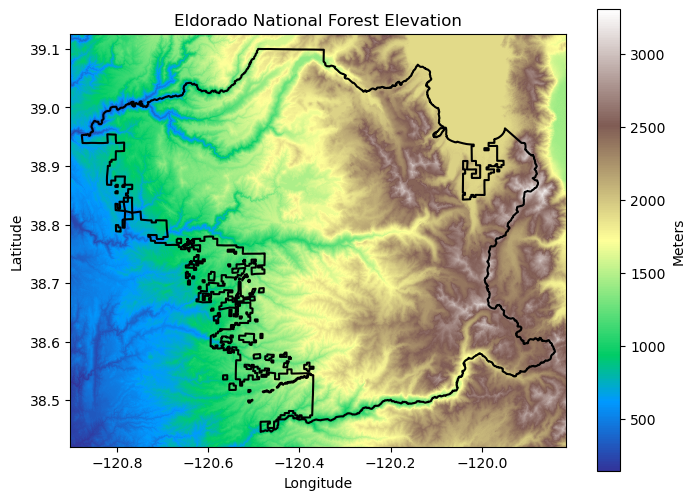

In [21]:
# Plot Eldorado elevation

eldorado_elev_plt = plot_site(
    eldorado_elev_da, eldorado_gdf, 
    'Eldorado-National-Forest-Elevation', 
    'Eldorado National Forest Elevation', 
    'Meters', 'terrain', 'black'
)

eldorado_elev_plt

In [22]:
los_padres_elev_da = select_dem(tuple(los_padres_gdf.total_bounds), los_padres_gdf, los_padres_elevation_dir)

QUEUEING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/11 [00:00<?, ?it/s]

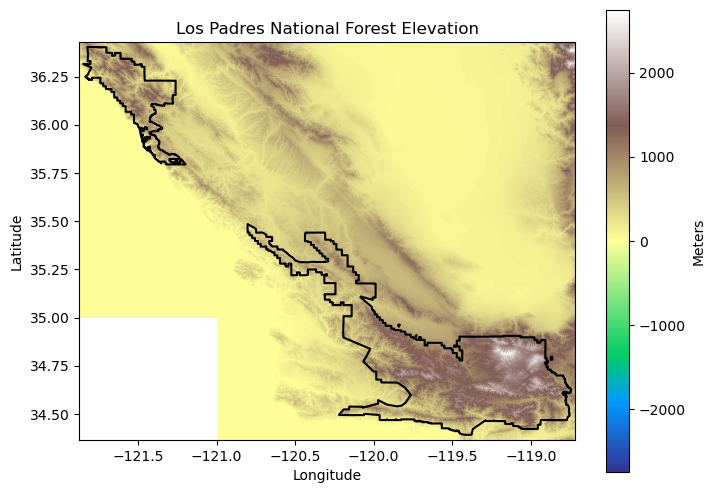

In [23]:
# Plot Los Padres elevation

los_padres_elev_plt = plot_site(
    los_padres_elev_da, los_padres_gdf, 
    'Los-Padres-Forest-Elevation', 
    'Los Padres National Forest Elevation', 
    'Meters', 'terrain', 'black'
)

los_padres_elev_plt

Calculate Aspect

In [24]:
"""
Prior to calculation, reproject to a coordinate system that uses meters as the units.

Selection: UTM (Universal Transverse Mercator) projection uses a grid system based on meter units.
For the sites, the UTM zone is 10.
"""

# EPSG code for UTM Zone 10: EPSG:32610
UTM_10_EPSG = 32610

def calculate_slope(elev_da, epsg_code):
    """Create slope DataArray from site elevation"""

    # Reproject latitude and longitude to meters for calculation
    elev_project_da = elev_da.rio.reproject(epsg_code)

    # Calculate site slope
    slope_da = xrspatial.slope(elev_project_da)

    return slope_da

In [25]:
def calculate_aspect(elev_da, epsg_code):
    """Create aspect DataArray from site elevation"""

    # Calculate aspect (degrees)
    aspect_da = xrspatial.aspect(elev_da)

    return aspect_da

In [26]:
help(xrspatial.aspect)

Help on function aspect in module xrspatial.aspect:

aspect(agg: xarray.core.dataarray.DataArray, name: Optional[str] = 'aspect') -> xarray.core.dataarray.DataArray
    Calculates the aspect value of an elevation aggregate.
    
    Calculates, for all cells in the array, the downward slope direction
    of each cell based on the elevation of its neighbors in a 3x3 grid.
    The value is measured clockwise in degrees with 0 (due north), and 360
    (again due north). Values along the edges are not calculated.
    
    Direction of the aspect can be determined by its value:
    From 0     to 22.5:  North
    From 22.5  to 67.5:  Northeast
    From 67.5  to 112.5: East
    From 112.5 to 157.5: Southeast
    From 157.5 to 202.5: South
    From 202.5 to 247.5: West
    From 247.5 to 292.5: Northwest
    From 337.5 to 360:   North
    
    Note that values of -1 denote flat areas.
    
    Parameters
    ----------
    agg : xarray.DataArray
        2D NumPy, CuPy, or Dask with NumPy-backed

In [27]:
# Calculate aspect

eldorado_aspect_da = calculate_aspect(eldorado_elev_da, UTM_10_EPSG)
los_padres_aspect_da = calculate_aspect(los_padres_elev_da, UTM_10_EPSG)

In [28]:
eldorado_aspect_da.head(25)

<xarray.DataArray 'aspect' (y: 25, x: 25)> Size: 2kB
array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [       nan,  93.65222 ,  86.729515,  88.21009 ,  91.27303 ,
         70.346176,  45.      ,  54.162346,  89.39691 , 101.30993 ,
        104.69732 , 105.25512 , 149.03624 , 233.36589 , 243.08345 ,
        248.08513 , 250.01689 , 250.94229 , 255.46555 , 261.8699  ,
        263.40326 , 261.5911  , 250.34618 , 230.71059 , 227.6264  ],
       [       nan,  95.47737 ,  81.11934 ,  77.38068 ,  70.01689 ,
         38.290165,  55.784298,  93.94518 , 100.34869 ,  93.36646 ,
         83.77417 ,  80.41705 ,  92.29061 , 253.61046 , 265.97174 ,
        269.30972 , 265.51538 , 261.29263 , 261.73282 , 260.18875 ,
        250.01689 , 235.1915  , 220.5444  , 215.27242 , 221.05481 ],
       [       nan,  81.32683 ,  82.64762 ,  81.869896,  69.90477 ,
         52.594643,  97.76517 , 111.46765 , 109.44003 ,  82.23483 ,
         60.642246,  69.623566,  94.2364  , 225.      , 245.89777 ,
        245.77225 , 243.17802 , 241.69925 , 242.2815  , 240.46121 ,
        234.0665  , 225.6296  , 219.4278  , 219.52263 , 226.61354 ],
...
        109.75947 , 117.012665, 109.653824, 106.645035, 231.3402  ,
        270.7073  , 269.3704  , 269.3969  , 273.50354 , 276.34018 ,
        275.9374  , 272.8624  , 265.6013  , 248.45903 , 204.71744 ,
        176.18593 , 171.76437 , 172.11687 , 169.27371 , 170.07376 ],
       [       nan, 115.30138 , 112.963776, 108.886086, 108.649536,
        116.56505 , 118.36119 , 115.46335 , 117.299576, 271.97495 ,
        275.19443 , 267.2073  , 266.63354 , 273.12213 , 278.1301  ,
        275.371   , 267.83893 , 249.84239 , 207.52522 , 179.46454 ,
        162.92899 , 157.0679  , 162.85445 , 164.55017 , 167.59258 ],
       [       nan, 130.99583 , 127.66562 , 117.19813 , 111.232895,
        116.35821 , 111.61478 , 100.30485 , 105.9454  , 252.40758 ,
        260.5377  , 260.16644 , 263.07278 , 265.23636 , 265.44623 ,
        259.99203 , 242.03777 , 205.16788 , 177.22978 , 170.53767 ,
        162.53607 , 156.64444 , 158.38522 , 159.8094  , 163.53246 ],
       [       nan, 141.009   , 138.53957 , 121.2284  , 112.619865,
        114.84239 , 114.94391 , 104.62087 , 114.274445, 228.17982 ,
        244.05771 , 244.38452 , 251.56505 , 252.42874 , 242.52557 ,
        227.17474 , 196.65431 , 178.28506 , 170.7274  , 165.35811 ,
        166.42957 , 168.35825 , 163.64761 , 157.28558 , 162.79514 ]],
      dtype=float32)
Coordinates:
  * x            (x) float64 200B -120.9 -120.9 -120.9 ... -120.9 -120.9 -120.9
  * y            (y) float64 200B 39.12 39.12 39.12 39.12 ... 39.12 39.12 39.12
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    units:          m
    _FillValue:     nan

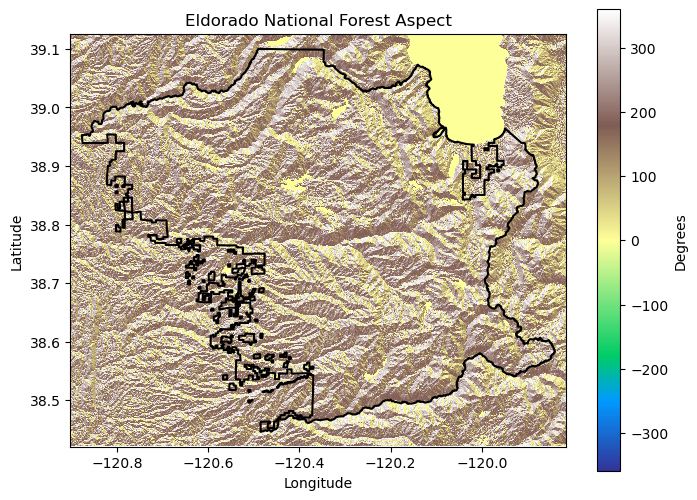

In [29]:
# Plot Eldorado aspect

eldorado_aspect_plt = plot_site(
    eldorado_aspect_da, eldorado_gdf, 
    'Eldorado-Forest-Aspect', 
    'Eldorado National Forest Aspect', 
    'Degrees', 'terrain', 'black'
)

eldorado_aspect_plt

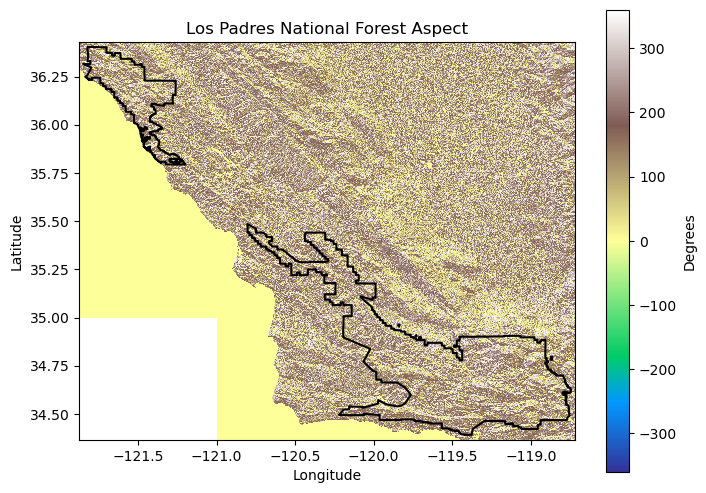

In [31]:
# Plot Los Padres aspect

los_padres_aspect_plt = plot_site(
    los_padres_aspect_da, los_padres_gdf,
    'Los-Padres-Forest-Aspect', 
    'Los Padres National Forest Aspect', 
    'Degrees', 'terrain', 'black'
)

los_padres_aspect_plt

In [ ]:
# Calculate site slope

eldorado_slope_da = calculate_slope(eldorado_elev_da, UTM_10_EPSG)
los_padres_slope_da = calculate_slope(los_padres_elev_da, UTM_10_EPSG)

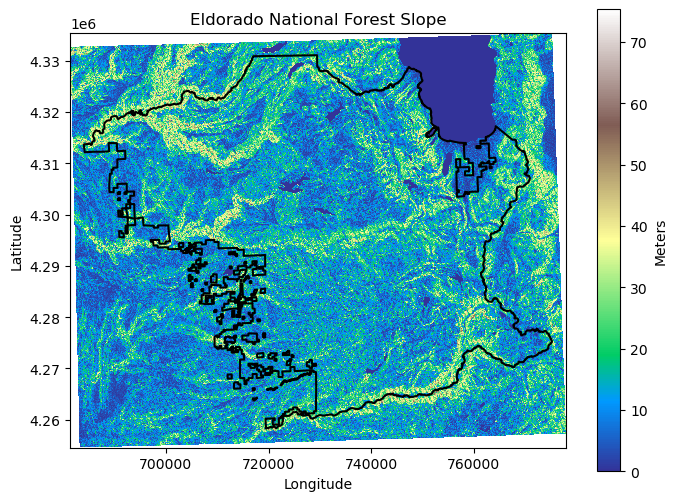

In [ ]:
# Plot Eldorado slope

eldorado_slope_plt = plot_site(
    # To plot boundary, reproject from lat/long to UTM_10_EPSG
    eldorado_slope_da, eldorado_gdf.to_crs(UTM_10_EPSG), 
    'Eldorado-Forest-Slope', 
    'Eldorado National Forest Slope', 
    'Meters', 'terrain', 'black'
)

eldorado_slope_plt

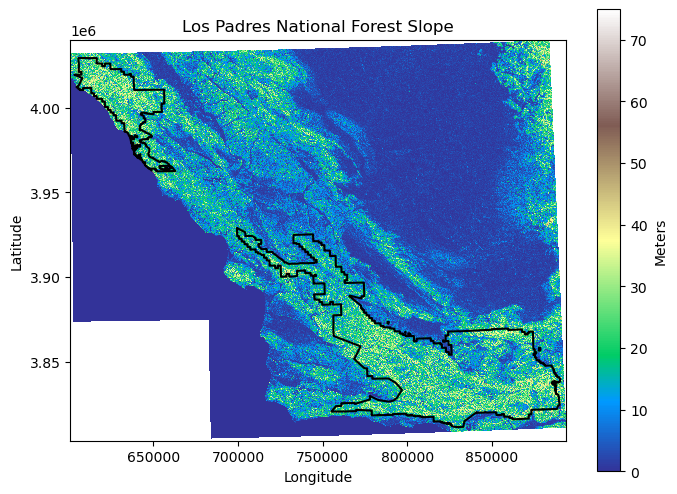

In [ ]:
# Plot Los Padres slope

los_padres_slope_plt = plot_site(
    # To plot boundary, reproject from lat/long to UTM_10_EPSG
    los_padres_slope_da, los_padres_gdf.to_crs(UTM_10_EPSG), 
    'Los-Padres-Forest-Slope', 
    'Los Padres National Forest Slope', 
    'Meters', 'terrain', 'black'
)

los_padres_slope_plt

Projected Climate

*Multivariate Adaptive Constructed Analogs (MACA) is a statistical method for downscaling Global Climate Models (GCMs) from their native coarse resolution to a higher spatial resolution.*

In [32]:
def get_projected_temperature(site_gdf_dict, emissions_scenarios, start_year, end_year):
    """Create DataFrame of projected site temperature"""

    maca_da_list = []

    for site_name, site_gdf in site_gdf_dict.items():
        for scenario in emissions_scenarios:
            
            MACA_URL = (
                'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2'
                f'/macav2metdata_tasmax_CanESM2_r1i1p1_{scenario}_{start_year}_{end_year}_CONUS_monthly.nc'
            )

            # Monthly Average of Daily Maximum Near-Surface Air Temperature
            maca_da = xr.open_dataset(MACA_URL).squeeze().air_temperature

            bounds = site_gdf.to_crs(maca_da.rio.crs).total_bounds

            # update coordinate range
            maca_da = maca_da.assign_coords(
                lon=("lon", [convert_longitude(l) for l in maca_da.lon.values])
            )

            maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

            maca_da = maca_da.rio.clip_box(*bounds)

            maca_da_list.append(dict(
                site_name=site_name,
                climate_scenario=scenario,
                da=maca_da)
            )

    maca_df = pd.DataFrame(maca_da_list)
    return maca_df 

In [ ]:
# RCP 4.5 (Medium Emissions Scenario) and 8.5 (High Emissions Scenario)
emissions_scenarios = ['rcp45', 'rcp85']
site_gdf_dict = {'eldorado': eldorado_gdf, 'los padres': los_padres_gdf}
start_year = '2096'
end_year = '2099'

site_proj_temp = get_projected_temperature(site_gdf_dict, emissions_scenarios, start_year, end_year)

site_proj_temp

site_name climate_scenario  \
0    eldorado            rcp45   
1    eldorado            rcp85   
2  los padres            rcp45   
3  los padres            rcp85   

                                                  da  
0  [[[<xarray.DataArray 'air_temperature' ()> Siz...  
1  [[[<xarray.DataArray 'air_temperature' ()> Siz...  
2  [[[<xarray.DataArray 'air_temperature' ()> Siz...  
3  [[[<xarray.DataArray 'air_temperature' ()> Siz...

Assess habitat suitability 

In [40]:
"""
Define thresholds for:
- soil_pH 
- elevation 
- Switching to aspect: North-facing better. See article in notes.
"""

"""
Template  
some value -> 0 (min incompatible) # mask
some value -> 1 (suitable start) # plot
some value -> 2 (suitable end) # mask
some value -> 3 (max incompatible) # mask 
NaN -> 4 # mask 
"""

template_classification = {
    0: -np.inf,
    1: 'value 1', # min value -> class 1 encapsulates suitability
    2: 'value 2', # max value
    3: np.inf
}

In [42]:
# Elevation suitability

# Los Padres
# This forest covers about 1.75 million acres of the Transverse and Coast Ranges in central and southern California. 
# Blue oak: The species is common between 76 and 915 m (250 and 3,000 ft) in the central Coast Range, and between 168 and 1370 m (550 and 4,500 ft) 
# in the Transverse Range.
# Elevation range = (76, 1370)

# Eldorado
# The elevation in Eldorado National Forest in California ranges from 1,000 feet in the foothills to over 10,000 feet along the Sierra crest.
# Blue oak: On west slopes of the Sierra Nevada, the species is abundant in the foothills at an elevational range of 152 to 915 m (500 to 3,000 ft).
# Elevation range = (152, 915)

# meters 
elevation_classification = {
    0: -np.inf,
    1: 76, # min value -> class 1 encapsulates suitability
    2: 1370, # max value
    3: np.inf
}

In [43]:
# Aspect suitability 

# degrees
aspect_classification = {
    0: -np.inf,
    1: 250, # min value -> class 1 encapsulates suitability
    2: 360, # max value
    3: np.inf
}

In [44]:
# Soil suitability 

# pH
soil_pH_classification = {
    0: -np.inf,
    1: 6, # min value -> class 1 encapsulates suitability
    2: 7.5, # max value
    3: np.inf
}

In [45]:
def get_habitat_suitability(site, scenario):
    """For a given site/climate scenario combination, identify and plot suitability"""

    

    # final step: plot the raster
